# Rush - Introduction

Rush is a classic rock band from Canada that has recorded 165 original songs on 19 studio albums.  I am a huge fan of the band's progressive rock era that spanned from 1974 to 1981.  You may have heard some of the songs from that time e.g. Closer To The Heart, Tom Sawyer, and Freewill. 

In this notebook, we will use data from Spotify to classify wether or not individual tracks were recorded during the band's progressive rock era.  

**Feature Description**

* name 
* album 
* release date 
* length 
* popularity  
* acousticness
* danceability 
* energy
* instrumentalness 
* liveness  
* loudness  
* speechiness 
* tempo 
* time_signature 
* progressive: 0 = not in the progressive rock era, 1 = in the progressive rock era



## Let's get started!

In [1]:
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
# Load the data as a dataframe
df = pd.read_csv("../input/spotifydata/spotify.csv")

# EDA 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              165 non-null    object 
 1   album             165 non-null    object 
 2   release_date      165 non-null    object 
 3   length            165 non-null    int64  
 4   popularity        165 non-null    int64  
 5   danceability      165 non-null    float64
 6   acousticness      165 non-null    float64
 7   energy            165 non-null    float64
 8   instrumentalness  165 non-null    float64
 9   liveness          165 non-null    float64
 10  loudness          165 non-null    float64
 11  speechiness       165 non-null    float64
 12  tempo             165 non-null    float64
 13  time_signature    165 non-null    int64  
 14  progressive       165 non-null    int64  
dtypes: float64(8), int64(4), object(3)
memory usage: 19.5+ KB


* The data has 165 observations, 14 feature columns and 1 target column.
* Let's to change time_signature and double_bass to categorical variables.

In [4]:
df['time_signature'] = df['time_signature'].map( {1:'1',3:'3',4:'4',5:'5'}).astype(object)
df['progressive'] = df['progressive'].map( {1:'1',0:'0'}).astype(object)

In [5]:
df.describe()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,1.650000e+02,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,3.240948e+05,35.800000,0.490745,0.058242,0.808359,0.079361,0.204821,-8.123879,0.047049,128.088303
std,1.477352e+05,9.187213,0.100090,0.135755,0.156146,0.176016,0.158320,2.417246,0.018114,21.280619
min,8.757300e+04,22.000000,0.202000,0.000006,0.033300,0.000000,0.047200,-23.826000,0.024800,78.003000
25%,2.640660e+05,29.000000,0.424000,0.000502,0.773000,0.000419,0.092300,-9.478000,0.034300,115.009000
50%,2.985330e+05,34.000000,0.500000,0.008970,0.854000,0.011300,0.143000,-7.926000,0.042400,126.741000
75%,3.376000e+05,40.000000,0.553000,0.055200,0.913000,0.055600,0.298000,-6.414000,0.053100,140.130000
max,1.233666e+06,73.000000,0.748000,0.966000,0.973000,0.866000,0.911000,-3.799000,0.123000,200.342000


* There are no missing values.
* We need to consider scaling the data because the means and standard deviations vary considerably between features.

In [6]:
df.columns.values

array(['name', 'album', 'release_date', 'length', 'popularity',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature',
       'progressive'], dtype=object)

Let's remove unnecessary features.

* name -  This variable is not helpful for this project.

* album and realease_date - These variables will be almost perfect predictors so we will remove them.

In [7]:
df.drop(['name','album','release_date'], axis = 1, inplace = True)

## progressive: the target variable

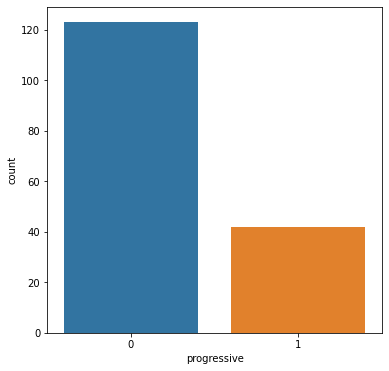

In [8]:
# Create plot space
fig=plt.figure(figsize = (6,6))

# Create plot
p = sns.countplot(x = df['progressive'], data = df)

The target variable is imbalanced.  We need to explore resampling methods.

## Numerical Data

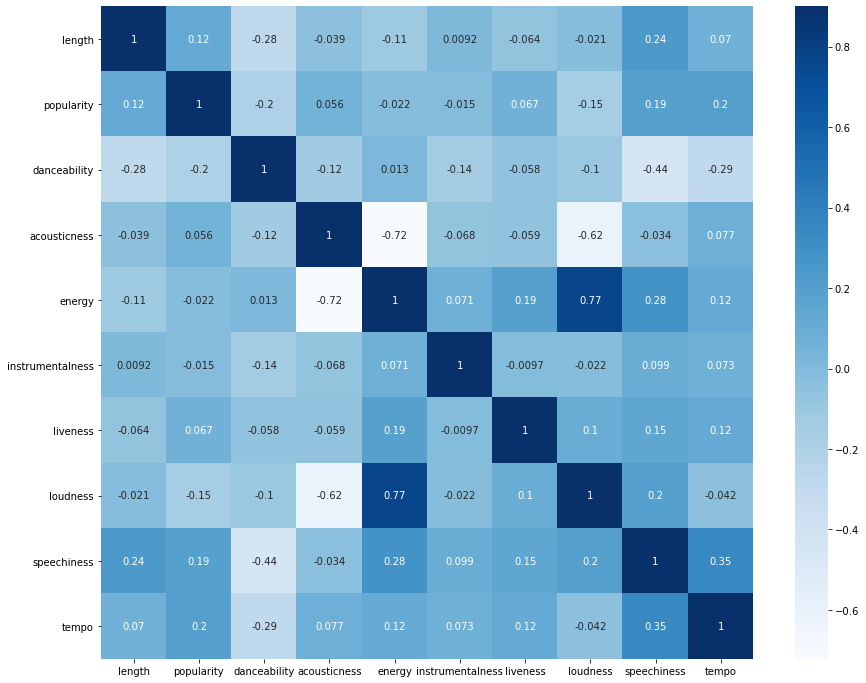

In [9]:
# Create plotting space
plt.subplots(figsize=(15,12))

# Calculate correlations
corr = df.corr()

# Plot the correlations
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True, annot=True)

* It seems there are two relationships that have high correlations.

* Energy and loudness have a correlation of .77.  This makes sense because loudness is a component of energy, according to Spotify's documentation shown below.
* "Typically, energetic tracks feel fast, **loud**, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, **perceived loudness**, timbre, onset rate, and general entropy."

* Energy and acousticness have a correlation of -.72.

* Let's compare energy and loudness to the target variable.

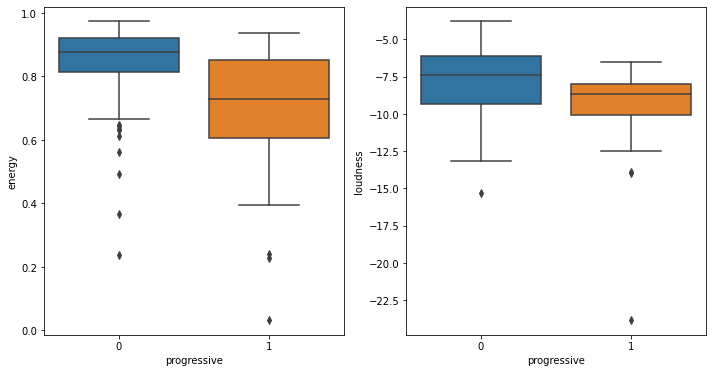

In [10]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
g = sns.boxplot(x="progressive", y="energy", data=df, ax=ax1) 

ax2 = fig.add_subplot(222)
g = sns.boxplot(x="progressive", y="loudness", data=df, ax=ax2) 

plt.close(2)
plt.close(3)
plt.tight_layout()

* It is hard to determine which of these varibales is a better predictor of the target variable.

* Let's perform a logistic regression to obatian a numerical determination.

In [11]:
# Reshape columns into array for logistic regression
loud = df['loudness']
loud = loud.to_numpy()
loud = loud.reshape(-1,1)

energy = df['energy']
energy  = energy .to_numpy()
energy  = energy .reshape(-1,1)

db = df['progressive']
db = db .to_numpy()
db = db .reshape(-1,1)

In [12]:
log1 = LogisticRegression()
log1.fit(loud, db)
print("Model accuracy: ", round(log1.score(loud,db),3))

Model accuracy:  0.758


In [13]:
log1 = LogisticRegression()
log1.fit(energy, db)
print("Model accuracy: ", round(log1.score(energy, db),3))

Model accuracy:  0.752


* The results are almost the same.  The common demnomitor between our two concerning correlations is energy, so let's remove it.
* This also takes care of the high correlation between energy and acousticness.

In [14]:
df.drop(['energy'], axis = 1, inplace = True)

### Let's explore the numerical variable distributions.

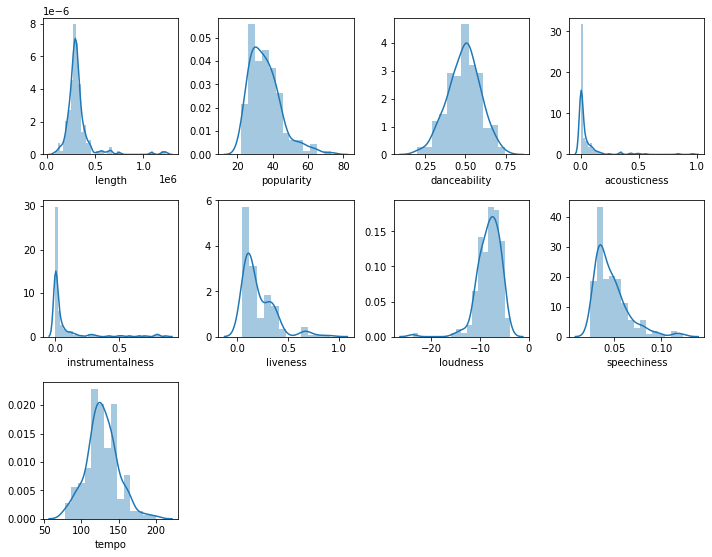

In [15]:
# Create dataset with only numerical values
numericaldata = df.select_dtypes(exclude='object')

# Create plot space
fig = plt.figure(figsize=(10,15))

# Create subplot for each loop
for i in range(len(numericaldata.columns)):
    fig.add_subplot(6,4,i+1)
    sns.distplot(numericaldata.iloc[:,i])
    plt.xlabel(numericaldata.columns[i])

# Display plots        
plt.tight_layout()
plt.show()

* Danceability and tempo are normally distributed.

* Let's looks at skew for each variable. Skew is significant when it is greater than 2 or less than -2. 

In [16]:
# Loop through each feature
for column in numericaldata:
    
    # calculate skew for feature
    sk = round(df[column].skew(), 2)
    
    # Print if skew is significant
    if sk > 2 or sk < -2:
        print("Skew for", column, "is", sk)

Skew for length is 3.85
Skew for acousticness is 4.15
Skew for instrumentalness is 3.11


* There are three variables with significant skew.

* Let's see how the skew changes after taking the natural logs of each variables.

In [17]:
# Loop through each feature
for column in ['length','acousticness', 'instrumentalness']:
    
    # calculate skew for feature after logging 
    sk = round(np.log(df[column]).skew(), 2)
    print("Skewness log of ", column, "is", sk)

Skewness log of  length is 0.86
Skewness log of  acousticness is -0.35
Skewness log of  instrumentalness is nan


* Intrumentalness' skew becomes nan after logging because the variable contain zeros.

* We will only take the natural log of length and acousticness.

In [18]:
for column in ['length', 'acousticness']:
    df[column] = np.log(df[column])

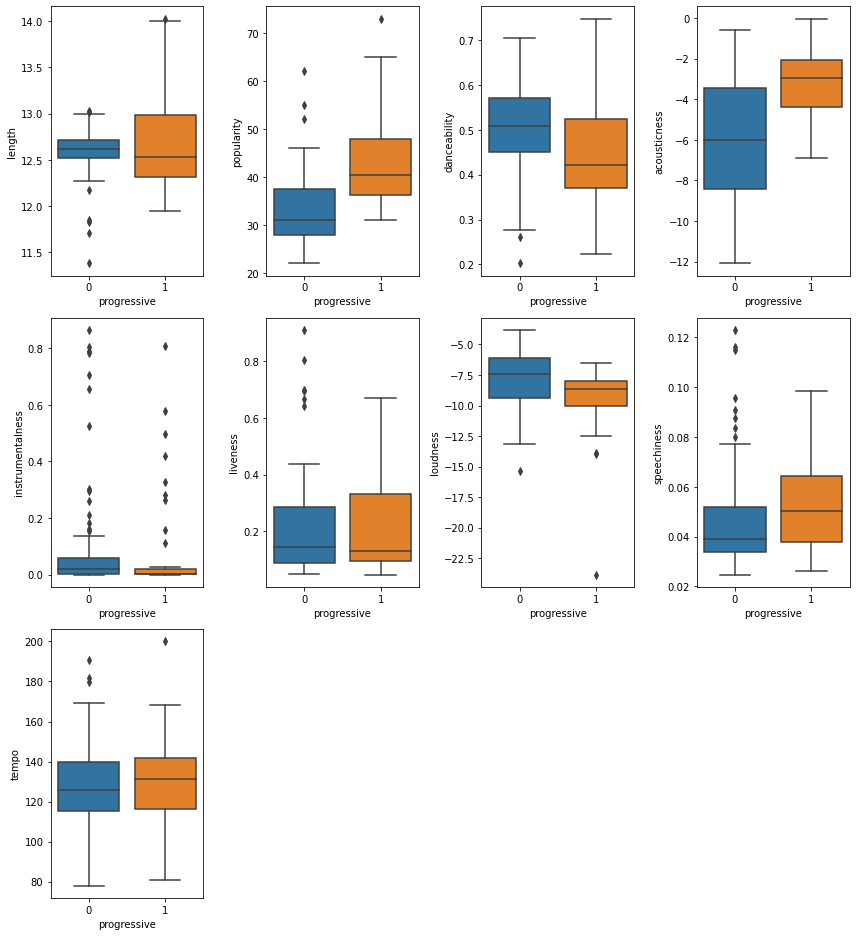

In [19]:
fig = plt.figure(figsize=(12,17))
col = list(df.columns.values[:9])
i = 0

for column in col:
    i = i
    fig.add_subplot(4,4,i+1)
    g = sns.boxplot(x="progressive", y=column, data=df)
    plt.tight_layout()
    i += 1

* I expect popularity, danceability, and acousticness to be significant predictors.
* There seems to be a significant difference in the mean popularity for the two levels of the progressive variable
* This is also true for danceability and acousticness.
* An additional reason I expect acousticness to be significant is that according to the boxplot(not the distribution plot), it is normally distributed.  Normally distributed variables tend to increase the accuracy of predictions.
* Tempo follows a normal distribuion, but its boxplot did not seem show significant differences for the two levels of progression.  Therefore, I do not expect it to be significant.

# Modeling


### You get bonus points if you understand why I've chosen 2112 for the random_state.

In [20]:
# Create test and train data
X = df.loc[:, df.columns != 'progressive']
y = df.progressive

X_train_org, X_test_org, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 2112)

# Create balanced training data
smote = SMOTE(sampling_strategy = 'minority', random_state = 2112)
X_train_smote, y_train_smote = smote.fit_sample(X_train_org, y_train)

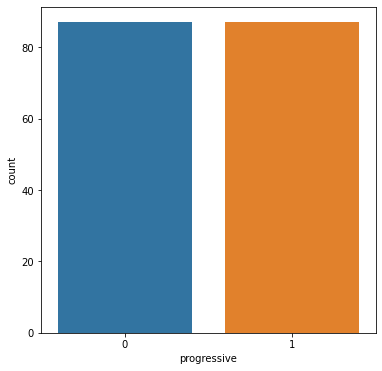

In [21]:
# Create plot space
fig=plt.figure(figsize = (6,6))

# Create plot
p = sns.countplot(x = y_train_smote, data = df)

## Random Forest Base Model

=== ROC Score ===
ROC - Random Forest:  0.827


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.933




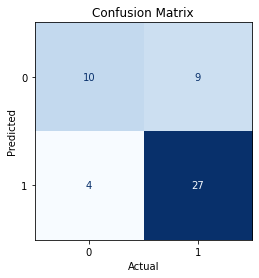

In [22]:
# Create the base model
base_model = RandomForestClassifier(random_state = 2112, n_estimators = 500)
base_model.fit(X_train_smote,y_train_smote)

# Create predictions
y_pred = base_model.predict(X_test_org)

# Create probabilities for ROC score
probs = base_model.predict_proba(X_test_org)
probs = probs[:,1]

# Calculate AUC score
auc_cv_score = cross_val_score(base_model, X_test_org, y_test, cv=10, scoring = "roc_auc")

# Print different model metrics
print("=== ROC Score ===")
print("ROC - Random Forest: ", round(roc_auc_score(y_test,probs),3))
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", round(np.nanmean(auc_cv_score), 3))
print('\n')
# I used nanmean above instead of mean because one of the AUC cross-validated results did not have any false positives.
# This resulted in a nan value.
# The nanmean function ignores nan values when calculating the mean.

labels = ["Actual","Predicted"]
cm = confusion_matrix(y_pred,y_test, labels=["1","0"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues") 
disp.ax_.set(xlabel='Actual',ylabel='Predicted', title = 'Confusion Matrix')
disp.im_.colorbar.remove()

In [23]:
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_org)

=== ROC Score ===
ROC - Random Forest:  0.824


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.958




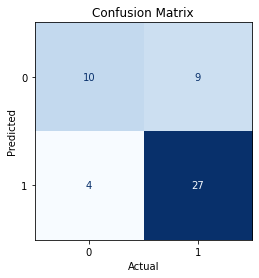

In [24]:
# Create the base model
base_model = RandomForestClassifier(random_state = 2112)
base_model.fit(X_train_smote_scaled,y_train_smote)

# Create predictions
y_pred = base_model.predict(X_test_scaled)

# Create probabilities for ROC score
probs = base_model.predict_proba(X_test_scaled)
probs = probs[:,1]

# Calculate AUC score
auc_cv_score = cross_val_score(base_model, X_test_scaled, y_test, cv=10, scoring = "roc_auc")

# Print various model metrics
print("=== ROC Score ===")
print("ROC - Random Forest: ", round(roc_auc_score(y_test,probs),3))
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", round(np.nanmean(auc_cv_score), 3)) 
print('\n')

# Plot the confusion matrix
labels = ["Actual","Predicted"]
cm = confusion_matrix(y_pred,y_test, labels=["1","0"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues") 
disp.ax_.set(xlabel='Actual',ylabel='Predicted', title = 'Confusion Matrix')
disp.im_.colorbar.remove()

* Scaling the data increased the AUC score to 0.958.  That went well!
* Below are the parameters for the basic model.

In [25]:
base_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2112,
 'verbose': 0,
 'warm_start': False}

* Let's tune the model's hyperparameters to improve the model.

## Random Forest Tuned

In [26]:
# Create the parameter grid
parameters = {'max_depth': range(2,15), #Maximum tree depth
              'max_features': ['auto', 'sqrt'], #Number of features to consider when looking for the best split
              'min_samples_leaf': [1,2,4,6,8,10,12], #Minimum number of samples required to be at a leaf node
              'min_samples_split': [1,2,4,6,8,10,12]} #The minimum number of samples required to split an internal node:
                         
# Create random forest model
rf_model = RandomForestClassifier(random_state=2112)

# Create exhaustive search over parameters
cv_rf = GridSearchCV(rf_model, cv = 10,
                     param_grid=parameters, n_jobs = -1)

# Fit the grid search to the training data
cv_rf.fit(X_train_smote_scaled, y_train_smote)

# Print the best parameters
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


=== ROC Score ===
ROC - Random Forest:  0.821


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.958




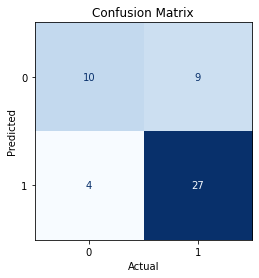

In [27]:
# Insert the best parameters into the model
rf_model.set_params(max_depth = 9, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2) 

# Fit the new model to the training data
rf_model.fit(X_train_smote_scaled,y_train_smote)

# Create predictions
y_pred = rf_model.predict(X_test_scaled)

# Create probabilities for ROC score
probs = rf_model.predict_proba(X_test_scaled)
probs = probs[:,1]

# Calculate AUC score
auc_cv_score = cross_val_score(rf_model, X_test_scaled, y_test, cv=10, scoring = "roc_auc")

# Print various model metrics
print("=== ROC Score ===")
print("ROC - Random Forest: ", round(roc_auc_score(y_test,probs),3))
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", round(np.nanmean(auc_cv_score), 3))
print('\n')

# Plot the confusion matrix
labels = ["Actual","Predicted"]
cm = confusion_matrix(y_pred,y_test, labels=["1","0"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues") 
disp.ax_.set(xlabel='Actual',ylabel='Predicted', title = 'Confusion Matrix')
disp.im_.colorbar.remove()

* The model did not improve.  I suspect this is due to the small size of the dataset.  
* Below is a plot of each feature's relative importance in the model.

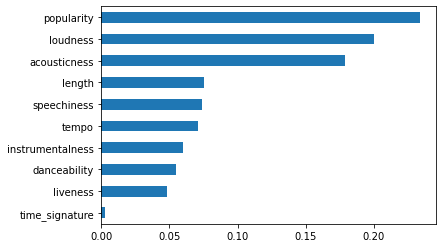

In [28]:
feat_importances = pd.Series(rf_model.feature_importances_, index=df.columns[:10])
feat_importances.nsmallest(10).plot(kind='barh')

I reran the models after dropping different numbers of the least important variables, but this did not significantly change the results.

In [29]:
#df.drop(['time_signature','danceability','length','liveness','instrumentalness','tempo','speechiness'], axis = 1, inplace = True)

# Conclusion

* I predicted that popularity, danceability, and acousticness would be significant variables.
* My intuitions about danceability and tempo were not correct.  Danceability is one of the least important variables, and tempo is one of the most important!
* FYI - I've tried dancing to a variety of Rush's music.  I wouldn't recommend it.  You may hurt yourself give the band's time signature changes.

Below is a summary of the AUC scores for each model.

* Base Model: .933
* Base Model Scaled: .958
* Tuned Model Scaled: .958

Final Thoughts

* The models that used scaled data performed the best.
* Unfortunately, I was not able to increase the model performance by tuning its hyperparameters.  I believe this is due to the small size of the dataset. 